In [ ]:
# Логистическая регрессия

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_classification

In [3]:
X,y = make_classification (n_samples=1000,
                          n_features=2,
                          n_informative=2,
                          n_redundant=0,
                          n_classes=2,
                          class_sep=2,
                          random_state=1) 
# Сгенерируем матрицу признаков и вектор целей для задачи классификации. make_classification генерирует случайное распределение по заданным параметрам. Число генерируемых точек данных задачи равным 1000, количество признаков - 2 для того, чтобы их можно было изобразить на графике. Оба признака будут информативными, то есть влиять на значение целевой переменной. Классов у нас тоже будет два, то есть будем решать задачу бинарной классификации. Параметр class_sep задает расстояние (зазор) между классами.

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
pd.DataFrame(X).head()

,0,1
0,1.863411,0.087646
1,-1.530997,1.901182
2,-0.017224,-2.591112
3,-2.032039,-1.801162
4,4.620555,0.901124


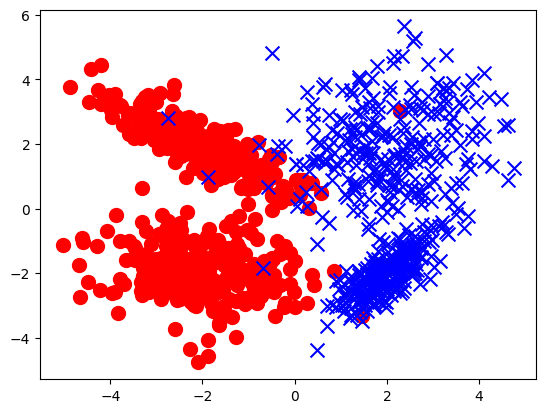

In [6]:
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=100)
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=100)
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
model = LogisticRegression()

In [10]:
model.fit(X, y)

LogisticRegression()

In [46]:
y_pred_lr = model.predict(X)
y_prob_lr = model.predict_proba(X)[:,1]

In [12]:
model.score(X, y)

0.976

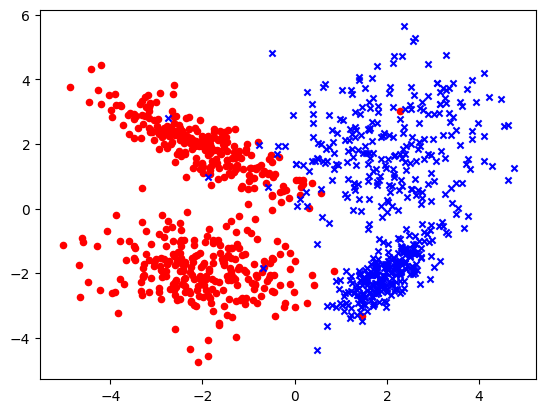

In [14]:
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], marker="o", c='r', s=20)
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], marker="x", c='b', s=20)
plt.show()

In [28]:
xx, yy = np.meshgrid(
    np.arange(X.min(axis=0)[0]-1, X.max(axis=0)[0]+1, 0.01), 
    np.arange(X.min(axis=0)[1]-1, X.max(axis=0)[1]+1, 0.01))
# В данном коде мы создаем двумерную матрицу, содержащую все комбинации значений признаков в заданном диапазоне. Другими словами, мы создаем равномерную сетку в прямоугольнике от минимального до максимального значения каждого признака (отступая для красоты 1 в обоих направлениях).

In [29]:
xx.shape

(1240, 1179)

In [32]:
XX = np.array(list(zip(xx.ravel(), yy.ravel()))).reshape((-1, 2))

In [43]:
Z = model.predict_proba(XX)[:,0].reshape(xx.shape)

In [34]:
Z.shape

(1240, 1179)

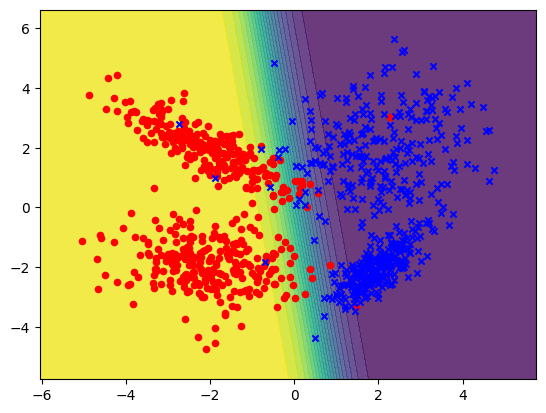

In [44]:
plt.contourf(xx, yy, Z, alpha=0.8, levels=20)
plt.scatter(X[y==0, 0], X[y==0, 1], marker="o", c='r', s=20)
plt.scatter(X[y==1, 0], X[y==1, 1], marker="x", c='b', s=20)


Accuracy: 0.976
Confusion matrix:
 [[485  14]
 [ 10 491]]


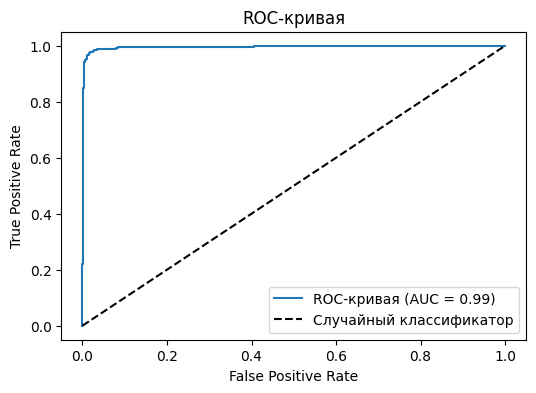

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# 1. Вывод результатов работы библиотечной модели в численном и графическом виде Выведите результаты работы библиотечной модели - в численном и в графическом виде.
acc = accuracy_score(y, y_pred_lr)
cm = confusion_matrix(y, y_pred_lr)
print("Accuracy:", acc)
print("Confusion matrix:\n", cm)

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(y, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label="Случайный классификатор")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

In [52]:
# Модифицируйте код модели таким образом, чтобы фиктивный столбец единиц добавлялся к матрице признаков внутри класса.
class SGD():
    def __init__(self, alpha=0.5, n_iters=1000):
        self.b = None
        self._alpha = alpha
        self._n_iters = n_iters
        
    def gradient_step(self, b, b_grad):
        return b - self._alpha * b_grad
    
    def optimize(self, X, y, start_b, n_iters):
        b = start_b.copy()
        for i in range(n_iters):
            b_grad = self.grad_func(X, y, b)
            b = self.gradient_step(b, b_grad)
        return b
    
    def fit(self, X, y):
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])  # Добавляем bias-столбец
        m = X_bias.shape[1]  # Обновляем количество признаков с учетом bias
        start_b = np.ones(m)  # Инициализация коэффициентов
        y = y.reshape(-1, 1) if y.ndim == 1 else y  # Приводим y к двумерному формату
        self.b = self.optimize(X_bias, y, start_b, self._n_iters)
        

In [53]:
class LogReg(SGD):
    def sigmoid(self, X, b):
        return 1. / (1. + np.exp(-X.dot(b)))

    def grad_func(self, X, y, b):
        n = X.shape[0]
        y = y.reshape(-1, 1) if y.ndim == 1 else y  # Приводим y к двумерному формату
        grad = (1. / n) * X.T.dot(self.sigmoid(X, b).reshape(-1, 1) - y)
        return grad.flatten()  # Приводим градиент к нужной форме

    def predict_proba(self, X):
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.sigmoid(X_bias, self.b)

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

In [66]:
# Пример использования:
# Сгенерируем бинарный датасет для логистической регрессии
from sklearn.datasets import make_classification

X_log, y_log = make_classification(n_samples=10000, n_features=10, n_redundant=3,
                                   n_informative=7, random_state=42, class_sep=2)

logreg = LogReg(alpha=0.1, n_iters=1000)
logreg.fit(X_log, y_log)
y_pred = logreg.predict(X_log)

In [67]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_log, y_pred)
f1 = f1_score(y_log, y_pred)
print(f'Custom LogReg accuracy = {acc:.2f}, F1-score = {f1:.2f}')

Custom LogReg accuracy = 0.97, F1-score = 0.97


In [69]:
y_pred_proba = logreg.predict_proba(X_log)
y_pred_proba

array([4.93325982e-04, 5.44389686e-02, 9.99977949e-01, ...,
       9.82539563e-01, 9.83401400e-01, 5.60931818e-05], shape=(10000,))

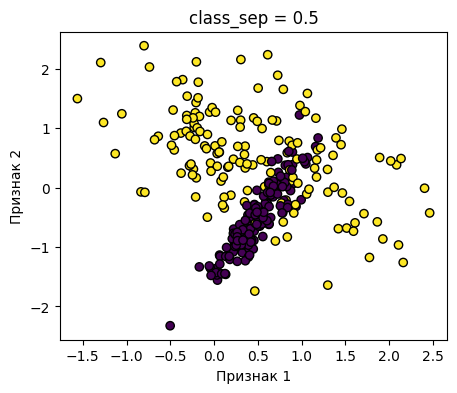

class_sep = 0.5 -> Accuracy: 0.7833


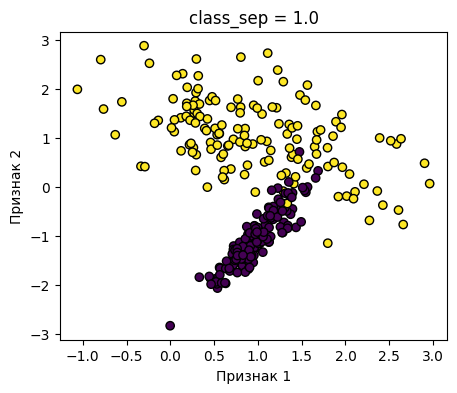

class_sep = 1.0 -> Accuracy: 0.9300


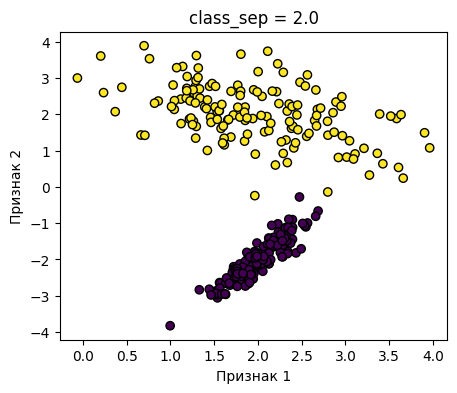

class_sep = 2.0 -> Accuracy: 0.9967


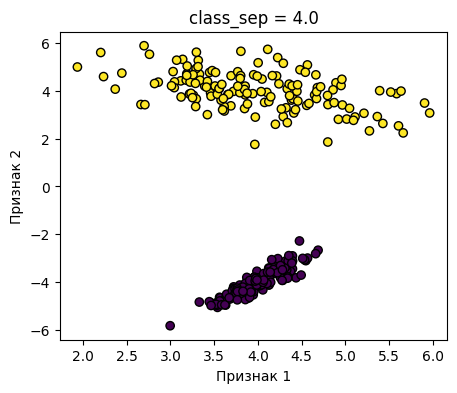

class_sep = 4.0 -> Accuracy: 1.0000


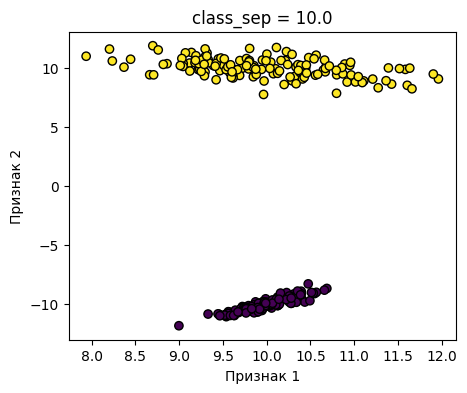

class_sep = 10.0 -> Accuracy: 1.0000


In [70]:
# 4. Поэкспериментируйте с разными значениями параметра class_sep при генерации датасета. Визуализируйте полученные распределения. Сделайте вывод о том, как этот параметр влияет на точность получаемых моделей.

class_sep_values = [0.5, 1.0, 2.0, 4.0, 10.0]
for sep in class_sep_values:
    X_sep, y_sep = make_classification(n_samples=300, n_features=2, n_redundant=0,
                                       n_informative=2, n_clusters_per_class=1,
                                       class_sep=sep, random_state=42)
    plt.figure(figsize=(5,4))
    plt.scatter(X_sep[:, 0], X_sep[:, 1], c=y_sep, cmap='viridis', edgecolor='k')
    plt.title(f'class_sep = {sep}')
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.show()
    
    model_sep = LogisticRegression()
    model_sep.fit(X_sep, y_sep)
    acc_sep = model_sep.score(X_sep, y_sep)
    print(f"class_sep = {sep} -> Accuracy: {acc_sep:.4f}")

In [ ]:
# при увеличении class_sep классы становятся лучше разделимыми, а точность модели (accuracy) возрастает.

In [73]:
# 5. Сгенерируйте датасет с большим числом признаков и примените к нему созданную модель.
X_many, y_many = make_classification(n_samples=500, n_features=50, n_informative=35,
                                     n_redundant=15, random_state=42)
logreg_many = LogisticRegression()
logreg_many.fit(X_many, y_many)
print("Accuracy для датасета с большим числом признаков:", logreg_many.score(X_many, y_many))

Accuracy для датасета с большим числом признаков: 0.868


In [76]:
from sklearn.multiclass import OneVsRestClassifier

# 7. Выведите значения вероятностей для каждого объекта принадлежать тому или иному классу для библиотечной модели LogisticRegression.
X_multi, y_multi = make_classification(n_samples=500, n_features=10, n_informative=5,
                                       n_classes=5, random_state=42)

# Используем OneVsRestClassifier
logreg_multi = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
logreg_multi.fit(X_multi, y_multi)

# Получение вероятностей
probs = logreg_multi.predict_proba(X_multi)

# Вывод вероятностей для первых 5 объектов
print("Вероятности для первых 5 объектов:\n", probs[:5])

Вероятности для первых 5 объектов:
 [[0.33647642 0.01888931 0.40829677 0.14340867 0.09292883]
 [0.09827434 0.10958056 0.5652886  0.16323927 0.06361724]
 [0.15096262 0.61603389 0.00560795 0.11224592 0.11514963]
 [0.33518436 0.01163109 0.43776976 0.20453757 0.01087722]
 [0.03238879 0.05723823 0.23585745 0.10194427 0.57257125]]
